In [3]:
### LATIHAN MEMBUAT DASHBOARD STREAMLIT
# membuat dataframe
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from babel.numbers import format_currency
sns.set(style='dark')

In [4]:
# create_daily_orders_df() digunakan untuk menyiapkan daily_orders_df
def create_daily_orders_df(df):
    daily_orders_df = df.resample(rule='D', on='order_date').agg({
        "order_id": "nunique",
        "total_price": "sum"
    })
    daily_orders_df = daily_orders_df.reset_index()
    daily_orders_df.rename(columns={
        "order_id": "order_count",
        "total_price": "revenue"
    }, inplace=True)
    
    return daily_orders_df

In [5]:
# create_sum_order_items_df() bertanggung jawab untuk menyiapkan sum_orders_items_df
def create_sum_order_items_df(df):
    sum_order_items_df = df.groupby("product_name").quantity_x.sum().sort_values(ascending=False).reset_index()
    return sum_order_items_df

In [6]:
# create_bygender_df() digunakan untuk menyiapkan bygender_df
def create_bygender_df(df):
    bygender_df = df.groupby(by="gender").customer_id.nunique().reset_index()
    bygender_df.rename(columns={
        "customer_id": "customer_count"
    }, inplace=True)
    
    return bygender_df

In [7]:
# create_byage_df() merupakan helper function yang digunakan untuk menyiapkan byage_df
def create_byage_df(df):
    byage_df = df.groupby(by="age_group").customer_id.nunique().reset_index()
    byage_df.rename(columns={
        "customer_id": "customer_count"
    }, inplace=True)
    byage_df['age_group'] = pd.Categorical(byage_df['age_group'], ["Youth", "Adults", "Seniors"])
    
    return byage_df

In [8]:
# create_bystate_df() digunakan untuk menyiapkan bystate_df
def create_bystate_df(df):
    bystate_df = df.groupby(by="state").customer_id.nunique().reset_index()
    bystate_df.rename(columns={
        "customer_id": "customer_count"
    }, inplace=True)
    
    return bystate_df

In [9]:
# create_rfm_df() bertanggung jawab untuk menghasilkan rfm_df
def create_rfm_df(df):
    rfm_df = df.groupby(by="customer_id", as_index=False).agg({
        "order_date": "max", #mengambil tanggal order terakhir
        "order_id": "nunique",
        "total_price": "sum"
    })
    rfm_df.columns = ["customer_id", "max_order_timestamp", "frequency", "monetary"]
    
    rfm_df["max_order_timestamp"] = rfm_df["max_order_timestamp"].dt.date
    recent_date = df["order_date"].dt.date.max()
    rfm_df["recency"] = rfm_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)
    rfm_df.drop("max_order_timestamp", axis=1, inplace=True)
    
    return rfm_df

In [10]:
# setelah menyiapkan beberapa helper function tersebut, tahap berikutnya ialah load berkas all_data.csv sebagai sebuah DataFrame
all_df = pd.read_csv("all_data.csv")

In [11]:
# all_df memiliki dua kolom yang bertipe datetime, yaitu order_date dan delivery_date.
# Kolom order_date inilah yang akan menjadi kunci dalam pembuatan filter nantinya.
# Sehingga kita perlu mengurutkan DataFrame berdasarkan order_date serta memastikan kedua kolom tersebut bertipe datetime
datetime_columns = ["order_date", "delivery_date"]
all_df.sort_values(by="order_date", inplace=True)
all_df.reset_index(inplace=True)
 
for column in datetime_columns:
    all_df[column] = pd.to_datetime(all_df[column])

In [12]:
# membuat filter dengan widget date input serta menambahkan logo perusahaan pada sidebar
min_date = all_df["order_date"].min()
max_date = all_df["order_date"].max()
 
with st.sidebar:
    # Menambahkan logo perusahaan
    st.image("https://github.com/dicodingacademy/assets/raw/main/logo.png")
    
    # Mengambil start_date & end_date dari date_input
    start_date, end_date = st.date_input(
        label='Rentang Waktu',min_value=min_date,
        max_value=max_date,
        value=[min_date, max_date]
    )

2023-10-06 06:04:44.789 
  command:

    streamlit run C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [14]:
# start_date dan end_date di atas akan digunakan untuk memfilter all_df. 
# Data yang telah difilter ini selanjutnya akan disimpan dalam main_df. 
# Proses ini dijalankan menggunakan kode berikut.
main_df = all_df[(all_df["order_date"] >= str(start_date)) & 
                (all_df["order_date"] <= str(end_date))]

In [15]:
# DataFrame yang telah difilter (main_df) inilah yang digunakan untuk menghasilkan
# berbagai DataFrame yang dibutuhkan untuk membuat visualisasi data
daily_orders_df = create_daily_orders_df(main_df)
sum_order_items_df = create_sum_order_items_df(main_df)
bygender_df = create_bygender_df(main_df)
byage_df = create_byage_df(main_df)
bystate_df = create_bystate_df(main_df)
rfm_df = create_rfm_df(main_df)

In [16]:
### Melengkapi Dashboard dengan Berbagai Visualisasi Data
st.header('Dicoding Collection Dashboard :sparkles:')

DeltaGenerator()

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

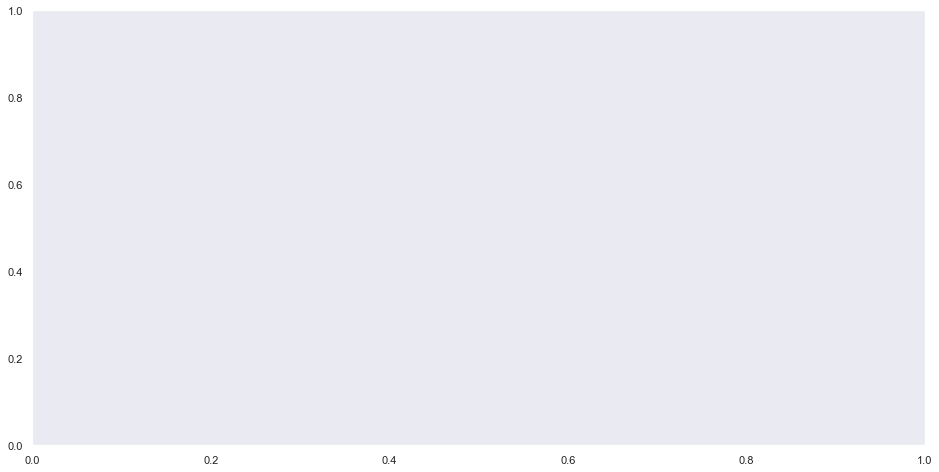

In [17]:
# menambahkan informasi terkait daily orders pada dashboard yang akan kita buat
st.subheader('Daily Orders')
 
col1, col2 = st.columns(2)
 
with col1:
    total_orders = daily_orders_df.order_count.sum()
    st.metric("Total orders", value=total_orders)
 
with col2:
    total_revenue = format_currency(daily_orders_df.revenue.sum(), "AUD", locale='es_CO') 
    st.metric("Total Revenue", value=total_revenue)
 
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(
    daily_orders_df["order_date"],
    daily_orders_df["order_count"],
    marker='o', 
    linewidth=2,
    color="#90CAF9"
)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=15)
 
st.pyplot(fig)

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be r

DeltaGenerator()

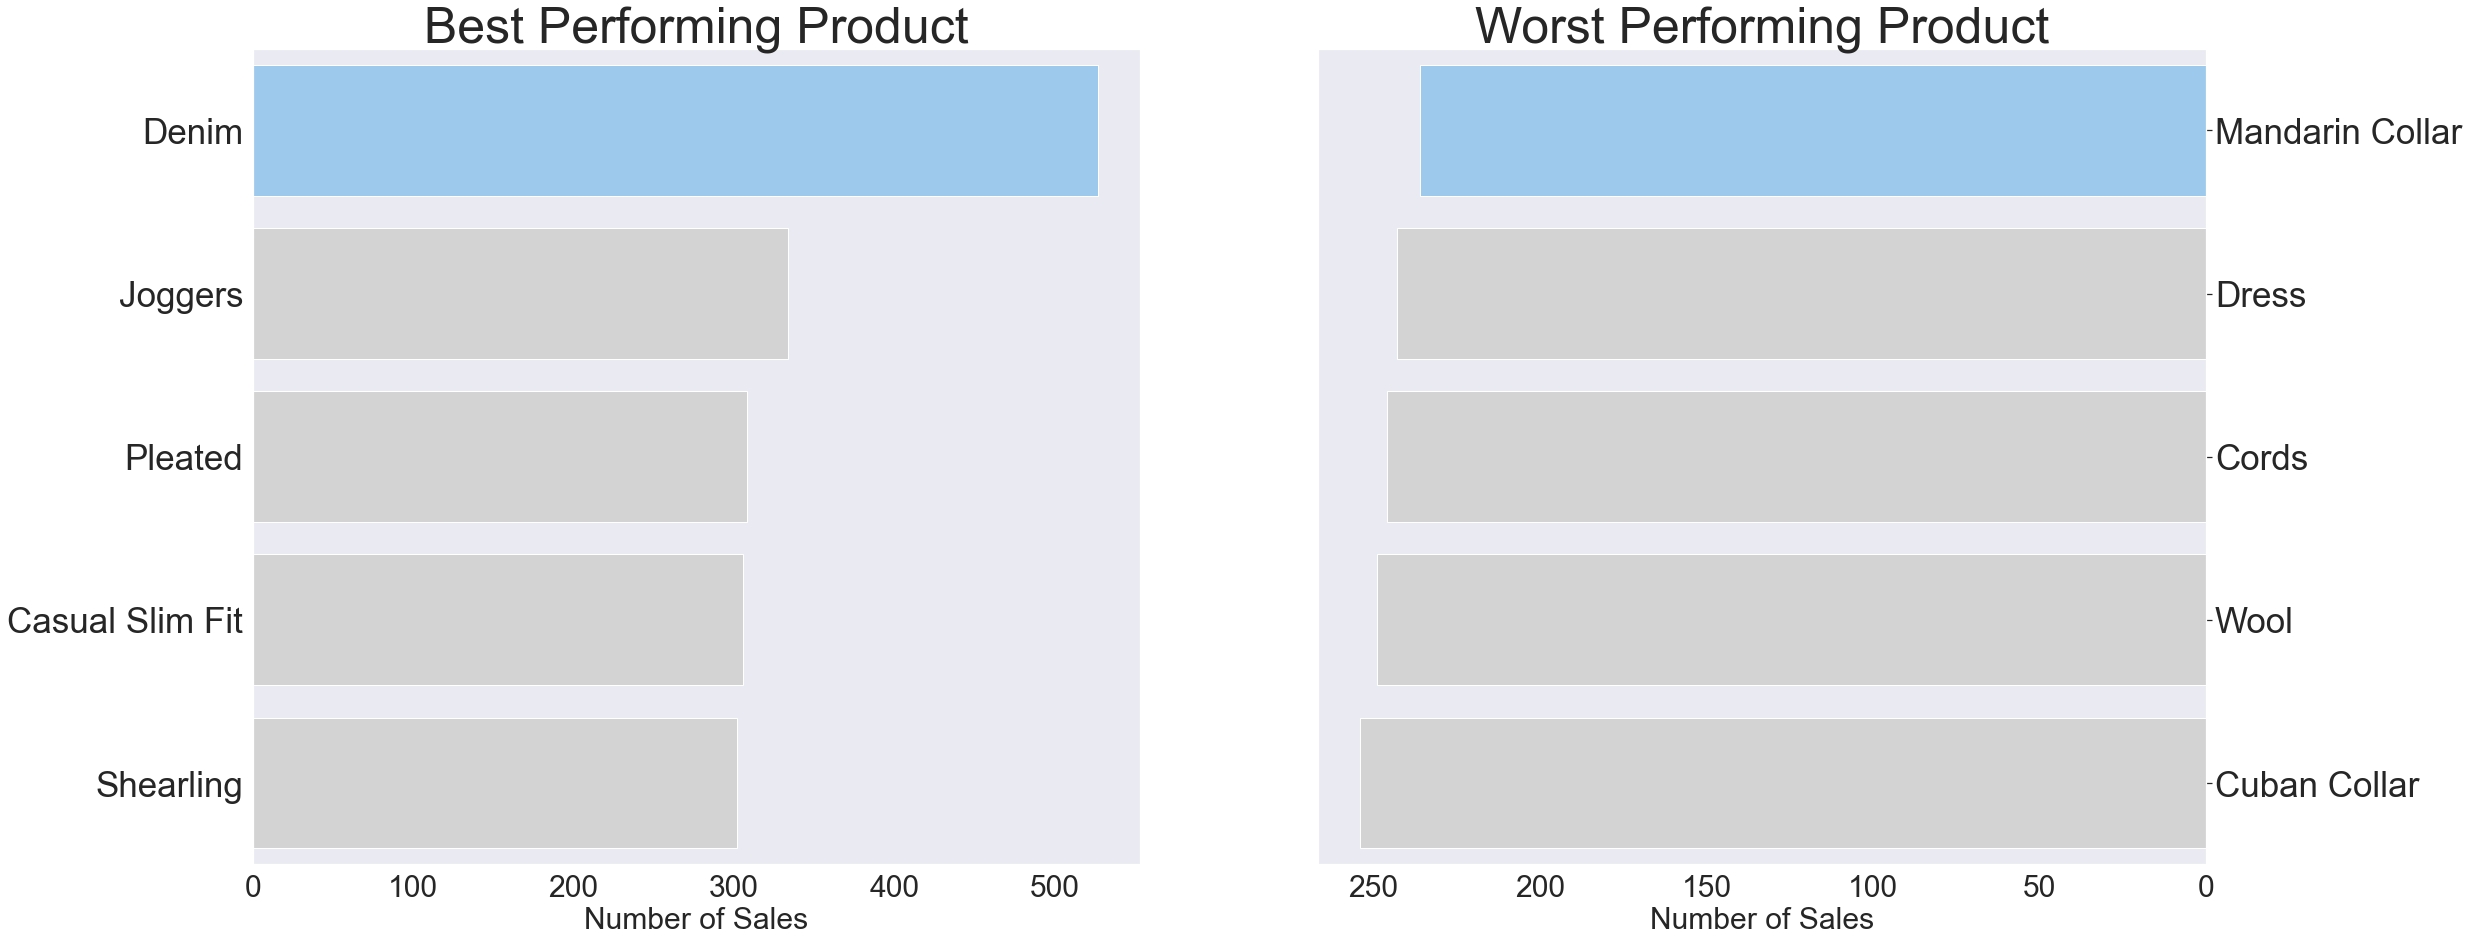

In [18]:
# menampilkan 5 produk paling laris dan paling sedikit terjual melalui sebuah visualisasi data
st.subheader("Best & Worst Performing Product")
 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(35, 15))
 
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
 
sns.barplot(x="quantity_x", y="product_name", data=sum_order_items_df.head(5), palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel("Number of Sales", fontsize=30)
ax[0].set_title("Best Performing Product", loc="center", fontsize=50)
ax[0].tick_params(axis='y', labelsize=35)
ax[0].tick_params(axis='x', labelsize=30)
 
sns.barplot(x="quantity_x", y="product_name", data=sum_order_items_df.sort_values(by="quantity_x", ascending=True).head(5), palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel("Number of Sales", fontsize=30)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Worst Performing Product", loc="center", fontsize=50)
ax[1].tick_params(axis='y', labelsize=35)
ax[1].tick_params(axis='x', labelsize=30)
 
st.pyplot(fig)

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be r

DeltaGenerator()

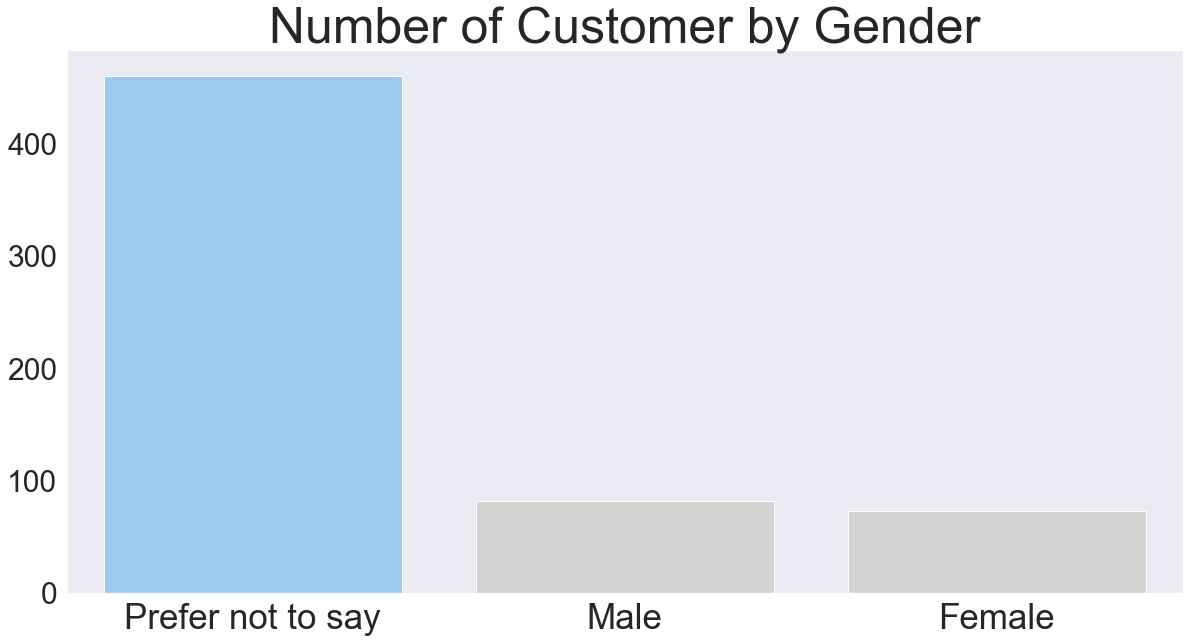

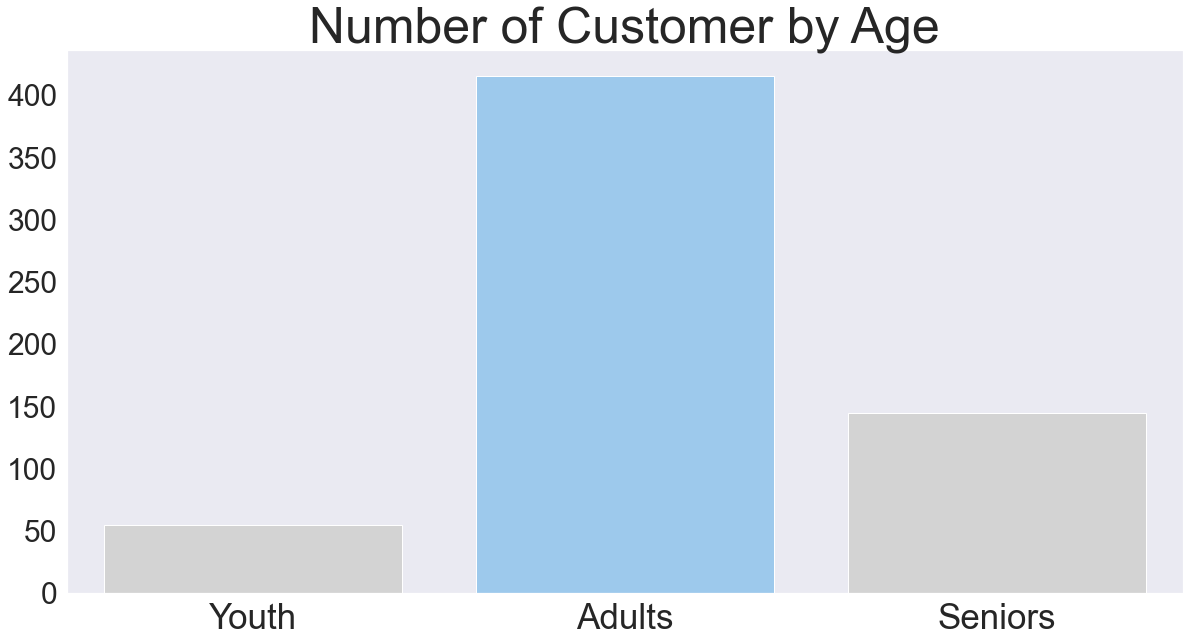

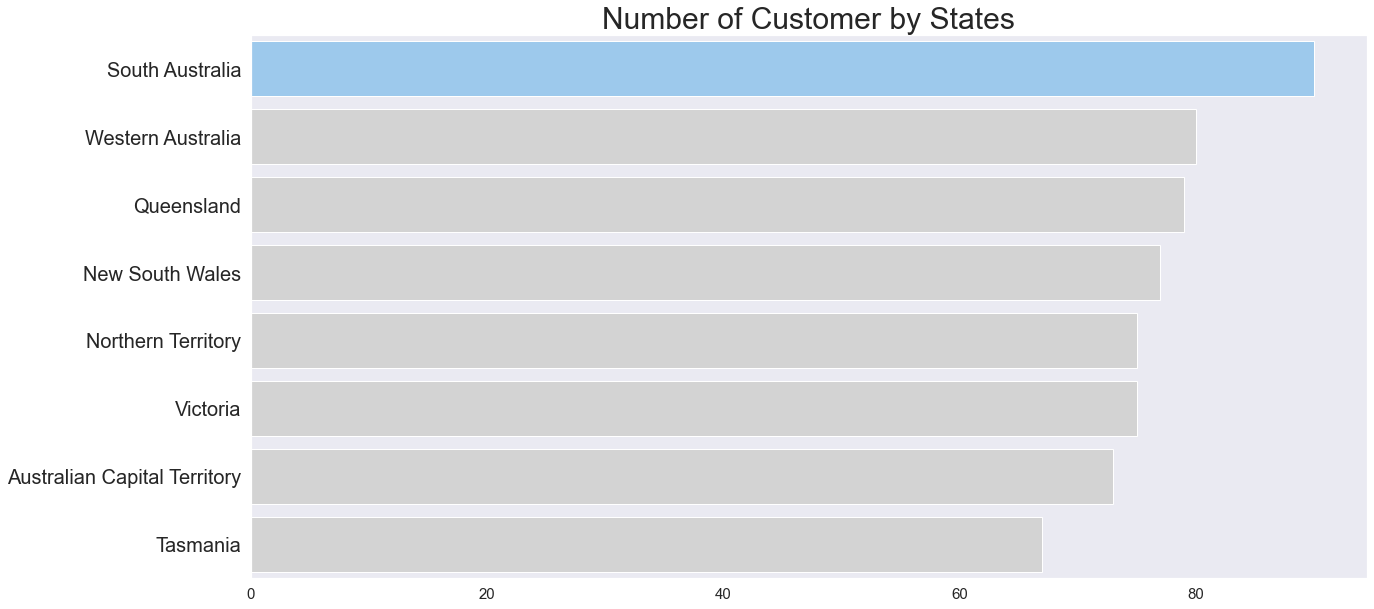

In [19]:
# menampilkan terkait demografi pelanggan yang kita miliki
st.subheader("Customer Demographics")
 
col1, col2 = st.columns(2)
 
with col1:
    fig, ax = plt.subplots(figsize=(20, 10))
 
    sns.barplot(
        y="customer_count", 
        x="gender",
        data=bygender_df.sort_values(by="customer_count", ascending=False),
        palette=colors,
        ax=ax
    )
    ax.set_title("Number of Customer by Gender", loc="center", fontsize=50)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.tick_params(axis='x', labelsize=35)
    ax.tick_params(axis='y', labelsize=30)
    st.pyplot(fig)
 
with col2:
    fig, ax = plt.subplots(figsize=(20, 10))
    
    colors = ["#D3D3D3", "#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
 
    sns.barplot(
        y="customer_count", 
        x="age_group",
        data=byage_df.sort_values(by="age_group", ascending=False),
        palette=colors,
        ax=ax
    )
    ax.set_title("Number of Customer by Age", loc="center", fontsize=50)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.tick_params(axis='x', labelsize=35)
    ax.tick_params(axis='y', labelsize=30)
    st.pyplot(fig)
 
fig, ax = plt.subplots(figsize=(20, 10))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(
    x="customer_count", 
    y="state",
    data=bystate_df.sort_values(by="customer_count", ascending=False),
    palette=colors,
    ax=ax
)
ax.set_title("Number of Customer by States", loc="center", fontsize=30)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=15)
st.pyplot(fig)

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be r

DeltaGenerator()

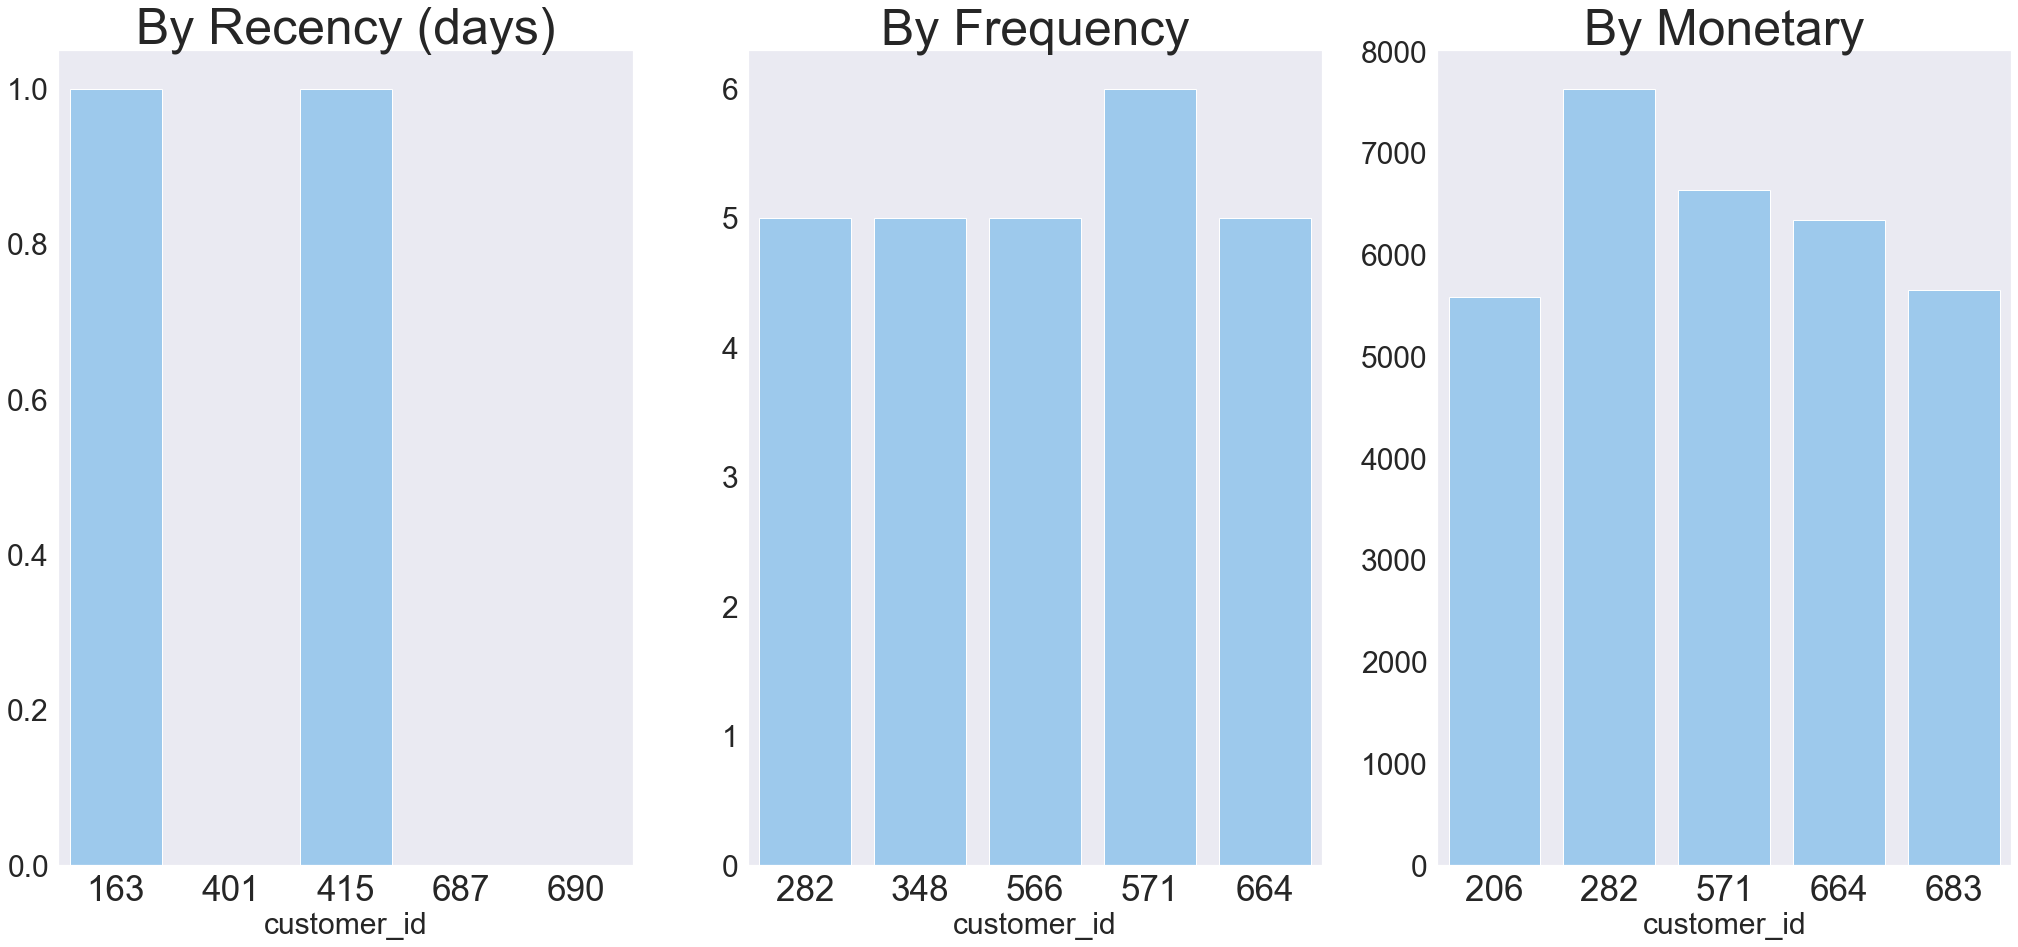

In [20]:
# Informasi terakhir yang harus kita tampilkan ialah terkait parameter RFM (Recency, Frequency, & Monetary)
st.subheader("Best Customer Based on RFM Parameters")
 
col1, col2, col3 = st.columns(3)
 
with col1:
    avg_recency = round(rfm_df.recency.mean(), 1)
    st.metric("Average Recency (days)", value=avg_recency)
 
with col2:
    avg_frequency = round(rfm_df.frequency.mean(), 2)
    st.metric("Average Frequency", value=avg_frequency)
 
with col3:
    avg_frequency = format_currency(rfm_df.monetary.mean(), "AUD", locale='es_CO') 
    st.metric("Average Monetary", value=avg_frequency)
 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(35, 15))
colors = ["#90CAF9", "#90CAF9", "#90CAF9", "#90CAF9", "#90CAF9"]
 
sns.barplot(y="recency", x="customer_id", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel("customer_id", fontsize=30)
ax[0].set_title("By Recency (days)", loc="center", fontsize=50)
ax[0].tick_params(axis='y', labelsize=30)
ax[0].tick_params(axis='x', labelsize=35)
 
sns.barplot(y="frequency", x="customer_id", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel("customer_id", fontsize=30)
ax[1].set_title("By Frequency", loc="center", fontsize=50)
ax[1].tick_params(axis='y', labelsize=30)
ax[1].tick_params(axis='x', labelsize=35)
 
sns.barplot(y="monetary", x="customer_id", data=rfm_df.sort_values(by="monetary", ascending=False).head(5), palette=colors, ax=ax[2])
ax[2].set_ylabel(None)
ax[2].set_xlabel("customer_id", fontsize=30)
ax[2].set_title("By Monetary", loc="center", fontsize=50)
ax[2].tick_params(axis='y', labelsize=30)
ax[2].tick_params(axis='x', labelsize=35)
 
st.pyplot(fig)
 
st.caption('Copyright (c) Dicoding 2023')